In [18]:
import os
from dotenv import load_dotenv
load_dotenv()
import pandas as pd
import json
import numpy as np
import requests
pd.set_option('display.max_columns', None)


In [2]:

# URL de la primera API para obtener OCID para el año 2021
ocid_search_url = "https://datosabiertos.compraspublicas.gob.ec/PLATAFORMA/api/search_ocds?search=agua&year=2021"

# Realiza una solicitud GET para obtener los OCID
response = requests.get(ocid_search_url)

# Verifica si la solicitud fue exitosa
if response.status_code == 200:
    # Convierte la respuesta JSON en un DataFrame de pandas
    data = response.json()
    df_ocids = pd.DataFrame(data['data'])

    # Obtén la lista de OCIDs
    ocid_list = df_ocids['ocid'].tolist()

    # URL de la segunda API para obtener información adicional por OCID
    record_api_url = "https://datosabiertos.compraspublicas.gob.ec/PLATAFORMA/api/record?ocid="

    # Itera a través de los OCIDs y obtiene información adicional
    all_contract_data = []
    for ocid in ocid_list:
        full_url = record_api_url + ocid
        response = requests.get(full_url)
        if response.status_code == 200:
            contract_data = response.json()
            all_contract_data.append(contract_data)
        else:
            print(f"No se pudo obtener información para OCID: {ocid}")

    # Convierte la lista de resultados en un DataFrame
    df_contract_info = pd.DataFrame(all_contract_data)
    
    # Ahora tienes un DataFrame (df_contract_info) que contiene la información detallada para cada OCID.

    # Puedes manipular y analizar estos datos según tus necesidades.
else:
    print("La solicitud para obtener OCIDs no fue exitosa.")

# Función para explorar y extraer las llaves anidadas en un JSON
def find_nested_keys(data, parent_key='', separator='_'):
    items = {}
    if isinstance(data, list):
        for i, item in enumerate(data):
            items.update(find_nested_keys(item, f"{parent_key}{separator}{i}", separator))
    elif isinstance(data, dict):
        for key, value in data.items():
            new_key = f"{parent_key}{separator}{key}" if parent_key else key
            items.update(find_nested_keys(value, new_key, separator))
    else:
        items[parent_key] = data
    return items

# Aplicar la función a la columna 'releases'
keys_dict = df_contract_info['releases'].apply(find_nested_keys).apply(pd.Series)

# Concatenar el DataFrame de las llaves extraídas con el DataFrame original
df_contract_info = pd.concat([df_contract_info, keys_dict], axis=1)

# Eliminar la columna 'releases' si ya no se necesita
df_contract_info.drop(columns=['releases'], inplace=True)

# Renombrar las columnas
df_contract_info.columns = df_contract_info.columns.str.replace('\d+_', '').str.replace('_', ' ').str.replace('0', '')

/var/folders/s7/2y3h3pk5083g_g_9p2dgfd_c0000gn/T/ipykernel_9247/332449210.py:54: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  keys_dict = df_contract_info['releases'].apply(find_nested_keys).apply(pd.Series)


# GCP

In [2]:
import os

# Establece la variable de entorno GOOGLE_APPLICATION_CREDENTIALS
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'key.json'


In [7]:
import requests
import pandas as pd
from google.cloud import storage
from datetime import datetime

# Configura la URL base de la API
base_api_url = "https://datosabiertos.compraspublicas.gob.ec/PLATAFORMA/api/"

# Función para obtener OCIDs de un año específico
def get_ocids(year):
    ocid_search_url = f"{base_api_url}search_ocds?search=agua&year={year}"
    response = requests.get(ocid_search_url)
    if response.status_code == 200:
        data = response.json()
        df_ocids = pd.DataFrame(data['data'])
        return df_ocids['ocid'].tolist()
    else:
        raise Exception("La solicitud para obtener OCIDs no fue exitosa.")

# Función para obtener información adicional por OCID
def get_contract_info(ocid):
    record_api_url = f"{base_api_url}record?ocid={ocid}"
    response = requests.get(record_api_url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"No se pudo obtener información para OCID: {ocid}")
        return None

# Función para guardar datos en Google Cloud Storage
def save_to_gcs(bucket_name, data, blob_name):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_string(data.to_csv(index=False), content_type='text/csv')

# Nombre del bucket de Google Cloud Storage donde se guardarán los datos
bucket_name = os.getenv('bucket_name')

# Año actual y mes actual
current_year = datetime.now().year
current_month = datetime.now().month

# Verifica si los datos ya existen para el año y mes actual
existing_blob_name = f"datos/{current_year}/{current_month}.csv"
try:
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(existing_blob_name)
    blob.download_as_text()
    print("Los datos para el mes actual ya existen en GCS.")
except Exception as e:
    # Los datos no existen, se obtienen y almacenan
    ocids = get_ocids(current_year)
    all_contract_data = []
    for ocid in ocids:
        contract_data = get_contract_info(ocid)
        if contract_data:
            all_contract_data.append(contract_data)
    
    df_contract_info = pd.DataFrame(all_contract_data)

    # Aplica la función find_nested_keys y realiza la limpieza de datos
    keys_dict = df_contract_info['releases'].apply(find_nested_keys).apply(pd.Series)
    df_contract_info = pd.concat([df_contract_info, keys_dict], axis=1)
    df_contract_info.drop(columns=['releases'], inplace=True)
    df_contract_info.columns = df_contract_info.columns.str.replace('\d+_', '').str.replace('_', ' ').str.replace('0', '')

    # Guarda los datos en Google Cloud Storage
    save_to_gcs(bucket_name, df_contract_info, existing_blob_name)
    print(f"Los datos para el mes actual se han almacenado en GCS: {existing_blob_name}")


/var/folders/s7/2y3h3pk5083g_g_9p2dgfd_c0000gn/T/ipykernel_9247/2037453755.py:64: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  keys_dict = df_contract_info['releases'].apply(find_nested_keys).apply(pd.Series)


Los datos para el mes actual se han almacenado en GCS: datos/2023/9.csv


# Obtener datos de la API - Solo OCID

## Version 1: Colocar un maximo de paginacion

In [ ]:
import requests
import pandas as pd
from google.cloud import storage

# Función para obtener OCIDs de un año específico y una página específica
def get_ocids(year, page):
    ocid_search_url = f"https://datosabiertos.compraspublicas.gob.ec/PLATAFORMA/api/search_ocds?page={page}&year={year}"
    response = requests.get(ocid_search_url)
    if response.status_code == 200:
        data = response.json()
        return data.get('data', [])
    else:
        raise Exception(f"La solicitud para obtener OCIDs no fue exitosa para el año {year} y la página {page}.")

# Nombre del bucket de Google Cloud Storage donde se guardarán los datos
bucket_name = os.getenv('bucket_name')

# Año que deseas recuperar
year_to_retrieve = 2017

# Número máximo de páginas a procesar (ajusta este valor)
max_pages_to_process = 100  # Por ejemplo, procesar las primeras 10 páginas

# Obtiene el número de páginas para el año seleccionado
ocid_search_url = f"https://datosabiertos.compraspublicas.gob.ec/PLATAFORMA/api/search_ocds?page=1&year={year_to_retrieve}"
response = requests.get(ocid_search_url)
if response.status_code == 200:
    data = response.json()
    total_pages = data.get('pages', 0)
else:
    raise Exception(f"No se pudo obtener información para el año {year_to_retrieve}.")

# Limita el número de páginas a procesar
total_pages = min(total_pages, max_pages_to_process)

# Itera a través de las páginas para obtener los OCIDs y almacenarlos en GCS
for page in range(1, total_pages + 1):
    ocids = get_ocids(year_to_retrieve, page)
    if ocids:
        # Convierte los datos en un DataFrame
        df_ocids = pd.DataFrame(ocids)
        
        # Define un nombre de archivo único para cada página
        file_name = f"datos/{year_to_retrieve}/ocids_{year_to_retrieve}_page_{page}.csv"
        
        # Guarda el DataFrame en Google Cloud Storage
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(file_name)
        blob.upload_from_string(df_ocids.to_csv(index=False), content_type='text/csv')
        
        print(f"Los OCIDs para la página {page} del año {year_to_retrieve} se han almacenado en GCS: {file_name}")


## V2 Paginacion cada n pasos

In [ ]:
import requests
import pandas as pd
from google.cloud import storage

# Función para obtener OCIDs de un año específico y una página específica
def get_ocids(year, page):
    ocid_search_url = f"https://datosabiertos.compraspublicas.gob.ec/PLATAFORMA/api/search_ocds?page={page}&year={year}"
    response = requests.get(ocid_search_url)
    if response.status_code == 200:
        data = response.json()
        return data.get('data', [])
    else:
        raise Exception(f"La solicitud para obtener OCIDs no fue exitosa para el año {year} y la página {page}.")

# Nombre del bucket de Google Cloud Storage donde se guardarán los datos
bucket_name = os.getenv('bucket_name')

# Año que deseas recuperar
year_to_retrieve = 2022
max_pages = 19546
page_jump = 100  # Número de páginas para saltar en cada iteración

# Obtiene el número de páginas para el año seleccionado
ocid_search_url = f"https://datosabiertos.compraspublicas.gob.ec/PLATAFORMA/api/search_ocds?page=1&year={year_to_retrieve}"
response = requests.get(ocid_search_url)
if response.status_code == 200:
    data = response.json()
    total_pages = data.get('pages', 0)
else:
    raise Exception(f"No se pudo obtener información para el año {year_to_retrieve}.")

# Itera a través de las páginas para obtener los OCIDs y almacenarlos en GCS
page = 1
while page <= total_pages:
    ocids = get_ocids(year_to_retrieve, page)
    if ocids:
        # Convierte los datos en un DataFrame
        df_ocids = pd.DataFrame(ocids)
        
        # Define un nombre de archivo único para cada página
        file_name = f"datos/{year_to_retrieve}/ocids_{year_to_retrieve}_page_{page}.csv"
        
        # Guarda el DataFrame en Google Cloud Storage
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(file_name)
        blob.upload_from_string(df_ocids.to_csv(index=False), content_type='text/csv')
        
        print(f"Los OCIDs para la página {page} del año {year_to_retrieve} se han almacenado en GCS: {file_name}")
    
    # Avanza al siguiente conjunto de páginas
    page += page_jump


# Cargar Bigquery

Eliminar tablas:

In [ ]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()

# Especifica el proyecto y el conjunto de datos donde deseas eliminar las tablas.
project_id = os.getenv('project_id')
dataset_id = os.getenv('dataset_id')

# Lista todas las tablas en el conjunto de datos.
tables = client.list_tables(f"{project_id}.{dataset_id}")

# Inicializa un contador para el número de tablas.
table_count = 0

# Elimina cada tabla en el conjunto de datos y aumenta el contador.
for table in tables:
    client.delete_table(table.reference, not_found_ok=True)
    table_count += 1

print(f"Deleted {table_count} tables in dataset '{project_id}.{dataset_id}'.")

Elimina una tabla

In [ ]:

from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()

# TODO(developer): Set table_id to the ID of the table to fetch.
table_id = f'{os.getenv("table_id")}.OCID_2015'

# If the table does not exist, delete_table raises
# google.api_core.exceptions.NotFound unless not_found_ok is True.
client.delete_table(table_id, not_found_ok=True)  # Make an API request.
print("Deleted table '{}'.".format(table_id))

Subida de archivos

In [90]:
from google.cloud import bigquery
from google.cloud.exceptions import BadRequest

# Construct a BigQuery client object.
client = bigquery.Client()

# lista_año = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
lista_año = [2015]

for año in lista_año:
    table_id = f'{os.getenv("table_id")}.OCID_{año}'

    schema = []

    table = bigquery.Table(table_id, schema=schema)
    table = client.create_table(table)  # Make an API request.
    print(
        "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
    )

    job_config = bigquery.LoadJobConfig(
        autodetect=True, source_format=bigquery.SourceFormat.CSV
    )
    uri = f"gs://{os.getenv('bucket_name')}/datos/{año}/*.csv"

    try:
        load_job = client.load_table_from_uri(
            uri, table_id, job_config=job_config
        )  # Make an API request.
        load_job.result()  # Waits for the job to complete.
        destination_table = client.get_table(table_id)
        print("Loaded {} rows.".format(destination_table.num_rows))
    except BadRequest as e:
        print(f"Error loading data for year {año}: {e}")
        # Handle the error here (e.g., log it, skip the file, etc.)

        # gsutil rm gs://iackathon/datos/2015/ocids_2015_page_8401.csv



Created table potent-shade-398114.iackathon.OCID_2015
Loaded 2350 rows.


# Model ML - Deteccion de anomalias

In [3]:
from google.cloud import bigquery
import pandas as pd

# Conecta con BigQuery
client = bigquery.Client()

# Realiza una consulta SQL para obtener los datos de la tabla específica en BigQuery
query = f"""
SELECT id, amount, method, locality, region, suppliers, buyer, year, month, internal_type
FROM {os.getenv("table_id")}.ocids_2020
"""

# Ejecuta la consulta y almacena los resultados en un DataFrame de Pandas
df = client.query(query).to_dataframe()

# Ahora puedes trabajar con los datos en el DataFrame 'df'


In [8]:
print(df.shape)
print(df.describe())
df.head()

(100, 10)
                 id         amount    year       month
count     100.00000     100.000000   100.0  100.000000
mean    84347.98000   18295.016762  2020.0    1.050000
std      6240.47138   68293.987323     0.0    0.219043
min     82872.00000       0.867600  2020.0    1.000000
25%     82901.75000     219.000000  2020.0    1.000000
50%     82926.50000    1814.137500  2020.0    1.000000
75%     82951.25000   23459.427600  2020.0    1.000000
max    112077.00000  672022.606080  2020.0    2.000000


,id,amount,method,locality,region,suppliers,buyer,year,month,internal_type
0,82944,7045.4608,direct,LOJA,LOJA,BENAVIDES MONTENEGRO JESSICA GABRIELA,EMPRESA ELECTRICA REGIONAL DEL SUR S.A.,2020,1,Catálogo electrónico - Compra directa
1,82947,6883.0272,direct,CUENCA,AZUAY,ASOCIACION DE SERVICIOS DE ALIMENTACION Y LIMP...,EMPRESA PÚBLICA DE LA UNIVERSIDAD DE CUENCA - ...,2020,1,Catálogo electrónico - Compra directa
2,82967,17100.7872,direct,CUENCA,AZUAY,PAIDA SACTA MIGUEL ANGEL,FUNDACION MUNICIPAL DE LA MUJER Y EL NIÑO DE C...,2020,1,Catálogo electrónico - Compra directa
3,82942,10.7520,selective,MONTUFAR,CARCHI,COMPAÑIA GENERAL DE COMERCIO COGECOMSA S. A.,GOBIERNO AUTONOMO DESCENTRALIZADO PARROQUIA RU...,2020,1,Catálogo electrónico - Mejor oferta
4,82936,5.2640,selective,MONTUFAR,CARCHI,COMPAÑIA GENERAL DE COMERCIO COGECOMSA S. A.,GOBIERNO AUTONOMO DESCENTRALIZADO PARROQUIA RU...,2020,1,Catálogo electrónico - Mejor oferta


In [9]:

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# Ingeniería de características y preprocesamiento (codificación de variables categóricas, etc.)

# Selecciona las características relevantes para el modelo
X = df[['amount', 'year', 'month']]

# Divide los datos en entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)  # Ajusta el tamaño de prueba según tus necesidades

# Entrena el modelo Isolation Forest en los datos de entrenamiento
model = IsolationForest(contamination=0.05, random_state=42)  # Ajusta el valor de 'contamination' y la semilla aleatoria según tus necesidades
model.fit(X_train)

# Detección de anomalías en los datos de prueba
test_scores = model.decision_function(X_test)
X_test['anomaly_score'] = test_scores

# Establece un umbral para detectar anomalías en los datos de prueba
threshold = X_test['anomaly_score'].quantile(0.95)

# Identifica las anomalías en los datos de prueba y almacena los id en una lista
anomalies = X_test[X_test['anomaly_score'] > threshold]
anomaly_ids = anomalies.index.tolist()

# Visualización de las anomalías o acciones posteriores

# Puedes exportar las anomalías a BigQuery, almacenarlas en Cloud Storage o tomar otras acciones según tus necesidades

print("Anomalías detectadas:")
print(anomalies)

print("IDs de anomalías:")
print(anomaly_ids)

Anomalías detectadas:
   amount  year  month  anomaly_score
4   5.264  2020      1       0.276408
IDs de anomalías:
[4]


In [12]:

# Selecciona las características relevantes para el modelo
X = df[['amount', 'year', 'month']]

# Divide los datos en entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)  # Ajusta el tamaño de prueba según tus necesidades

# Entrena el modelo Isolation Forest en los datos de entrenamiento
model = IsolationForest(contamination=0.05, random_state=42)  # Ajusta el valor de 'contamination' y la semilla aleatoria según tus necesidades
model.fit(X_train)

# Detección de anomalías en los datos de prueba
test_scores = model.decision_function(X_test)
X_test['anomaly_score'] = test_scores

# Establece un umbral para detectar anomalías en los datos de prueba
threshold = X_test['anomaly_score'].quantile(0.95)

# Identifica las anomalías en los datos de prueba y almacena los IDs de las anomalías
anomalies = X_test[X_test['anomaly_score'] > threshold]
anomaly_ids = anomalies.index.tolist()  # Lista de IDs de las anomalías

# Ahora, puedes buscar las filas correspondientes a las anomalías en el DataFrame original
anomaly_rows = df.loc[anomaly_ids]

# Visualización de las anomalías o acciones posteriores

# Puedes exportar las anomalías a BigQuery, almacenarlas en Cloud Storage o tomar otras acciones según tus necesidades

print("Anomalías detectadas:")
anomaly_rows

Anomalías detectadas:


,id,amount,method,locality,region,suppliers,buyer,year,month,internal_type
4,82936,5.264,selective,MONTUFAR,CARCHI,COMPAÑIA GENERAL DE COMERCIO COGECOMSA S. A.,GOBIERNO AUTONOMO DESCENTRALIZADO PARROQUIA RU...,2020,1,Catálogo electrónico - Mejor oferta


In [13]:
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
import numpy as np

/Users/mateoherasvera/Library/CloudStorage/OneDrive-Personal/GitHub/IAckathon/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateoherasvera/Library/CloudStorage/OneDrive-Personal/GitHub/IAckathon/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateoherasvera/Library/CloudStorage/OneDrive-Personal/GitHub/IAckathon/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateoherasvera/Library/C

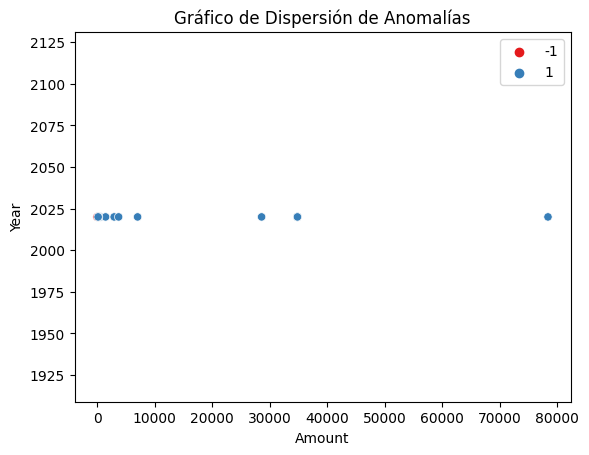

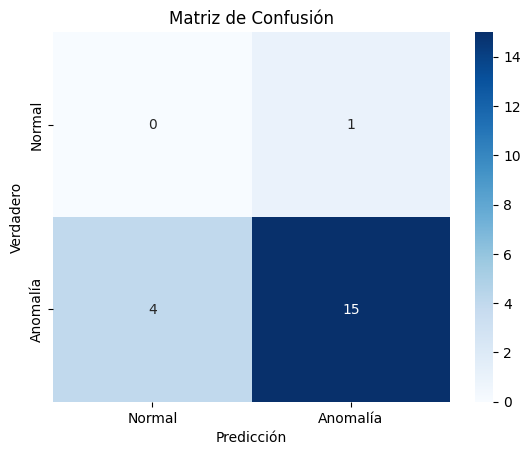

Informe de Clasificación:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         1
    Anomalía       0.94      0.79      0.86        19

    accuracy                           0.75        20
   macro avg       0.47      0.39      0.43        20
weighted avg       0.89      0.75      0.81        20



In [18]:

# Selecciona las características relevantes para el modelo
X = df[['amount', 'year', 'month']]

# Divide los datos en entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)  # Ajusta el tamaño de prueba según tus necesidades

# Entrena el modelo Isolation Forest en los datos de entrenamiento
model = IsolationForest(contamination=0.05, random_state=42)  # Ajusta el valor de 'contamination' y la semilla aleatoria según tus necesidades
model.fit(X_train)

# Detección de anomalías en los datos de prueba
test_scores = model.decision_function(X_test)

# Establece un umbral para detectar anomalías en los datos de prueba
threshold = np.percentile(test_scores, 95)  # Utiliza np.percentile para obtener el percentil 95

# Identifica las anomalías en los datos de prueba
y_pred = model.predict(X_test)

# Crear matriz de confusión
y_true = np.ones(len(X_test), dtype=int)  # Todos los puntos son considerados como normales (1) por defecto
y_true[test_scores > threshold] = -1  # Anomalías son etiquetadas como -1

# Gráfico de dispersión de anomalías
sns.scatterplot(data=X_test, x='amount', y='year', hue=y_true, palette='Set1')
plt.title("Gráfico de Dispersión de Anomalías")
plt.xlabel("Amount")
plt.ylabel("Year")
plt.show()

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalía'], yticklabels=['Normal', 'Anomalía'])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

# Informe de clasificación
print("Informe de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomalía']))